#Stock Price Prediction Using the Time Series Analysis

##Objetivo
Desarrollar un modelo de analisi de series temporales que prediga el precio futuro de acción (stock) usando datos historico , aplicando tecnicas estadisticas como ARIMA/SARIMA

###Objetivo Especifico
* Tomar datos historicos
* Limpiar y analizar los datos
* Crear un modelo que pueda predecir los precios de los próximos dias
* Evaluar qué tan preciso es ese modelo
* Visualizar comparaciones entre lo real y lo predicho

Procesos por hacer:
* Data Preprocessing (preprocesamiento de datos)
  - Importar el conjunto de datos, analizar y convertir datos
  - Manejar datos faltantes y valores atipicos
* EDA(Exploracion de analisis de datos)
  - Visualización de las tendencias del precio de las acciones a lo largo del tiempo
  - Descomponer la serie temporal para identificar sus componentes(tendencia, estcionalidad)
* Ingeniería de características
  - Crear características de desfase (lag features) y estadísticas móviles (rolling statistics)

  - Implementar diferenciación (differencing) para lograr la estacionariedad de la serie temporal

* Desarrollo del modelo
  - Aplicar modelos de predicción de series temporales como ARIMA y SARIMA

* Evaluación del modelo
  - Evaluar los modelos utilizando métricas como el Error Absoluto Medio (MAE)
  - Comparar los precios reales y los predichos mediante una gráfica

* Ajuste de hiperparámetros
  - Optimizar los parámetros del modelo para mejorar la precisión (accuracy)

* Reporte
  - Documentar el proceso de análisis
  - Interpretar los resultados y discutir el poder predictivo del modelo



#Data preprocessing
Los datos que usaremos seran los del conjunto de historial de precios de apple, que fueron obtenidos desde Keagle

####Acerca del Dataset:
Contiene todas las estadísticas diarias relacionadas con las operaciones de Apple (AAPL) desde 2010, incluyendo el precio de cierre, precio de apertura, precio máximo y volumen. (columnas: Date, Close/Last, Stock, Volume, Open,High, Low)


###Descargar e importar las librerias que vamos a usar

In [3]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install sklearn
!pip install statsmodels

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [4]:
#importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

####Importar el Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df = pd.read_csv('/content/drive/MyDrive/HistoricalQuotes.csv')
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,02/28/2020,$273.36,106721200,$257.26,$278.41,$256.37
1,02/27/2020,$273.52,80151380,$281.1,$286,$272.96
2,02/26/2020,$292.65,49678430,$286.53,$297.88,$286.5
3,02/25/2020,$288.08,57668360,$300.95,$302.53,$286.13
4,02/24/2020,$298.18,55548830,$297.26,$304.18,$289.23


In [7]:
df.shape

(2518, 6)

In [8]:
df.dtypes

,0
Date,object
Close/Last,object
Volume,int64
Open,object
High,object
Low,object


In [9]:
df.columns

Index(['Date', ' Close/Last', ' Volume', ' Open', ' High', ' Low'], dtype='object')

In [10]:
#ordenar las fehas y reiniciar el index
df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Convert currency columns to numeric
for col in [' Close/Last', ' Open', ' High', ' Low']:
    df[col] = df[col].astype(str).str.replace(r'[$,]', '', regex=True).astype(float)

# Quitar outliers extremos
q1 = df[" Close/Last"].quantile(0.01)
q99 = df[" Close/Last"].quantile(0.99)
df = df[(df[" Close/Last"] > q1) & (df[" Close/Last"] < q99)]

df.head()

,Date,Close/Last,Volume,Open,High,Low
0,01/02/2013,78.4328,139906732,79.1171,79.2857,77.3757
1,01/02/2014,79.0185,58661530,79.3828,79.5757,78.8601
2,01/02/2015,109.3300,53143770,111.3900,111.4400,107.3500
3,01/02/2018,172.2600,25400540,170.1600,172.3000,169.2600
4,01/02/2019,157.9200,35637070,154.8900,158.8500,154.2300


In [ ]:
df.dtypes

In [ ]:
#datos faltantes
df.isnull().sum()

In [ ]:
#datos atipicos
df.dropna(inplace=True)
df[' Close/Last']

#EDA (Exploratoory Data Analysis)
###Visualización de las tendencias del precio de las acciones a lo largo del tiempo
Esto con el objetivo de ver tendenicas, comportamientos y estacionalidad

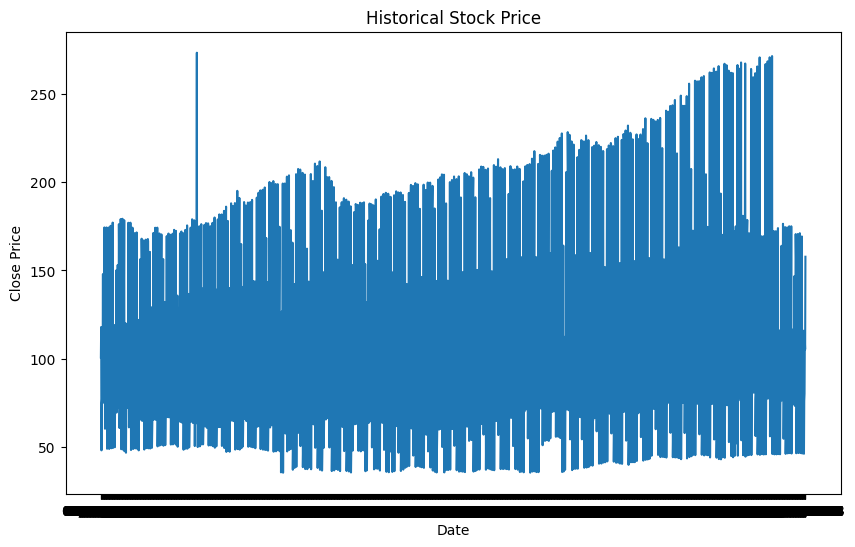

In [60]:
#Graficaremos el precio de cierre en el tiempo
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df[' Close/Last'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Historical Stock Price')
plt.show()

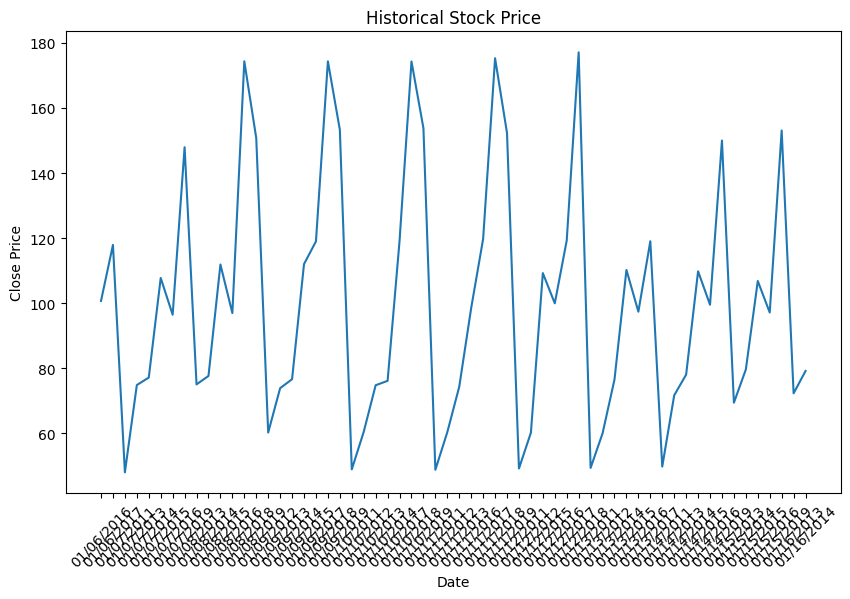

In [61]:
#vamos a mejorar laa visualizavion de datos
df_limite=df.head(60)
plt.figure(figsize=(10,6))
plt.plot(df_limite['Date'], df_limite[' Close/Last'])
plt.xlabel('Date')
plt.ylabel('Close Price')
x=plt.xticks(rotation=45)
plt.title('Historical Stock Price')
plt.show()

En los datos se puede observar que hay una tendencia de subida y bajada en el cierre, existen picos anormales de subidas y caudas drasticas, se analiza siempre que cuando hay una subida de precio le sigue un pico en bajada

Este mismo parece estable en cierto rango de tiempo pero no es del todo exacto.

###Visualización con media móvil(Tendencia suavizada)

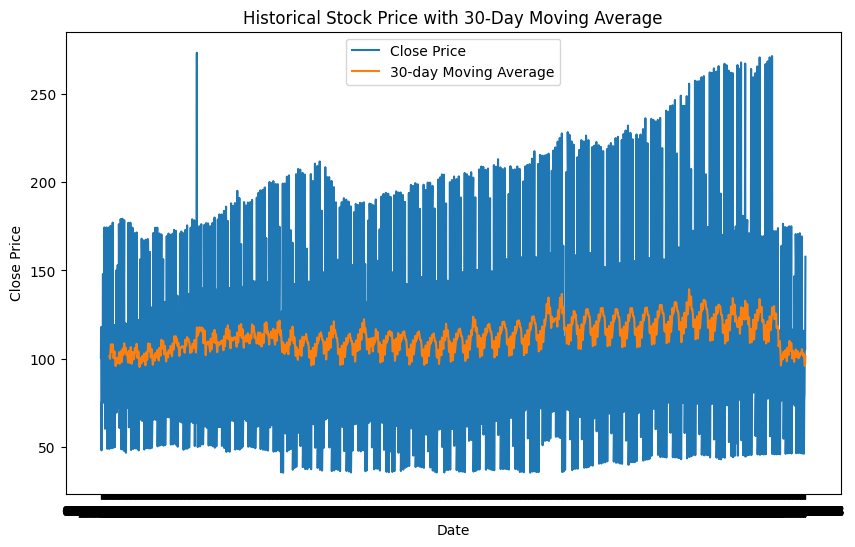

In [62]:
df['media_30']=df[' Close/Last'].rolling(window=30).mean()
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df[' Close/Last'], label='Close Price')
plt.plot(df['Date'], df['media_30'], label='30-day Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Historical Stock Price with 30-Day Moving Average')
plt.legend()

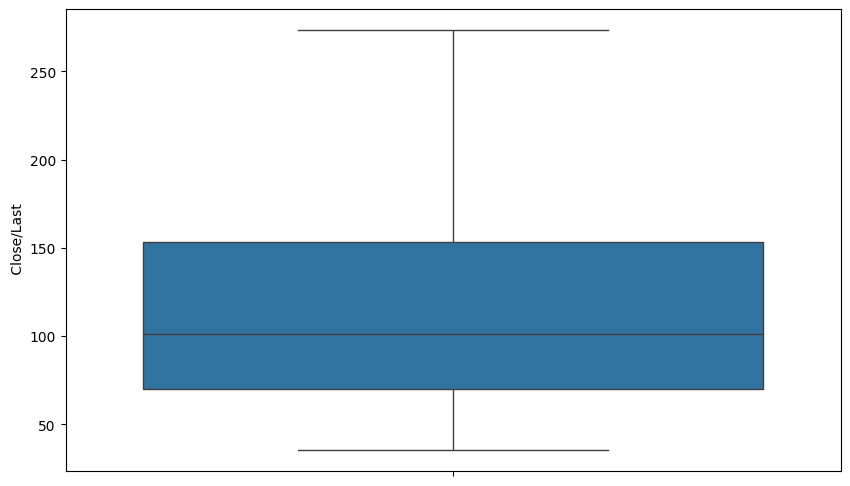

In [63]:
#haremos una revision rapida de los datos proporcionados al inicio
plt.figure(figsize=(10,6))
sns.boxplot(df[' Close/Last'])
plt.show()

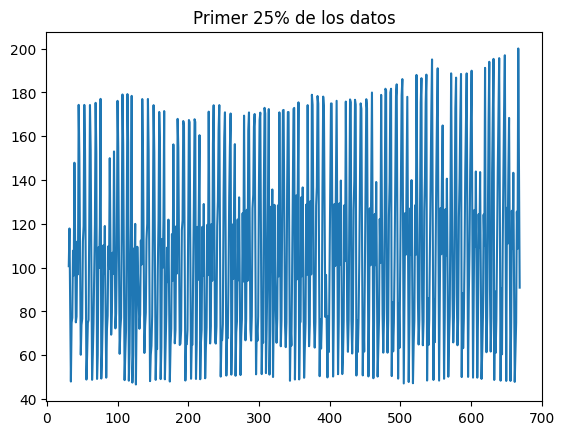

In [75]:
#Graficaremos solo el 25% ya que aqui en el grafico se ve qeu hay picos pronunciados
n=int(len(df)*0.25)
plt.plot(df[' Close/Last'].iloc[:n])
plt.title('Primer 25% de los datos')
plt.show()

In [88]:
#vamos a observar si eliminando de nuevo los outliers extremo
q1 = df[" Close/Last"].quantile(0.01)
q99 = df[" Close/Last"].quantile(0.99)
df = df[(df[" Close/Last"] > q1) & (df[" Close/Last"] < q99)]


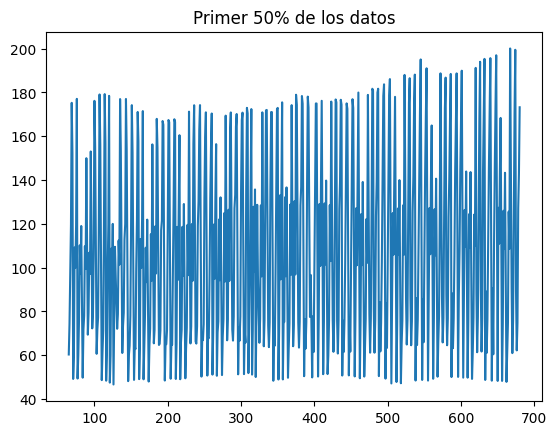

In [89]:
#graficaremos el 50% de los datos
n2=int(len(df)*0.25)
plt.plot(df[' Close/Last'].iloc[:n2])
plt.title('Primer 50% de los datos')
plt.show()

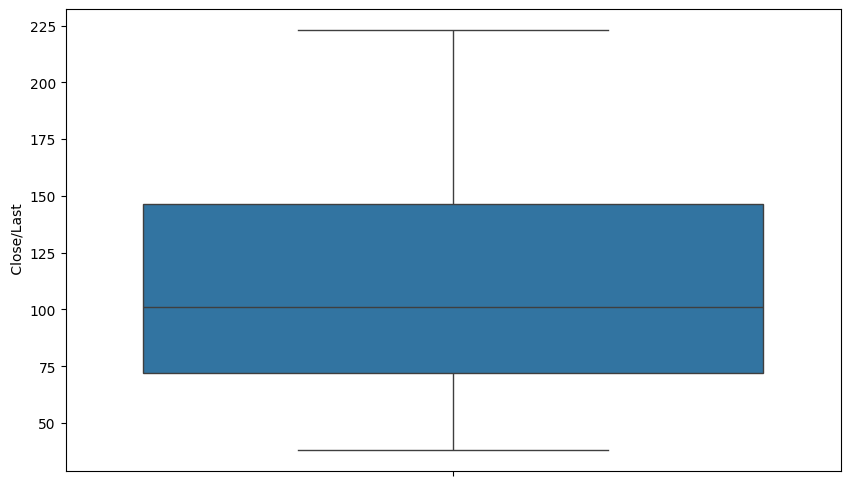

In [90]:
#realizaremos un boxplot para el analisis de estos datos
plt.figure(figsize=(10,6))
sns.boxplot(df[' Close/Last'])
plt.show()

/tmp/ipython-input-91-3356046438.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['media_30']=df[' Close/Last'].rolling(window=30).mean()


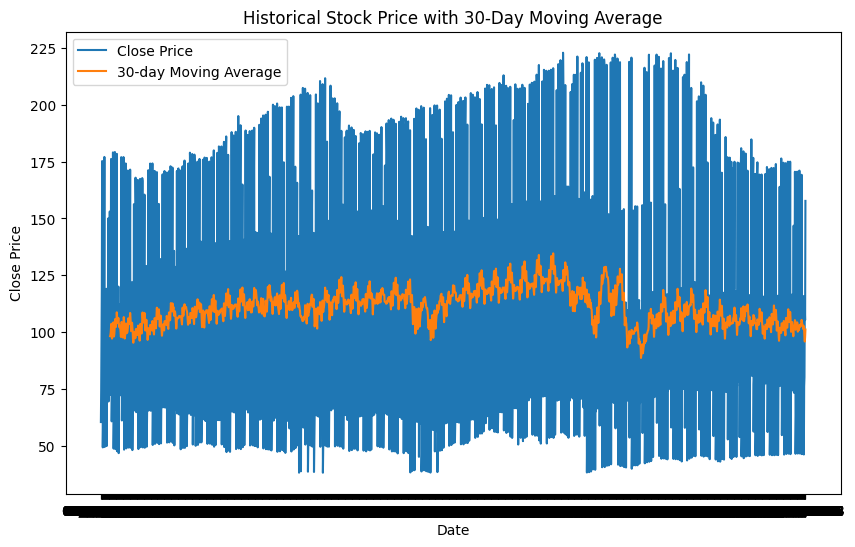

In [91]:
df['media_30']=df[' Close/Last'].rolling(window=30).mean()
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df[' Close/Last'], label='Close Price')
plt.plot(df['Date'], df['media_30'], label='30-day Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Historical Stock Price with 30-Day Moving Average')
plt.legend()

###Descomposicion de la serie temporal

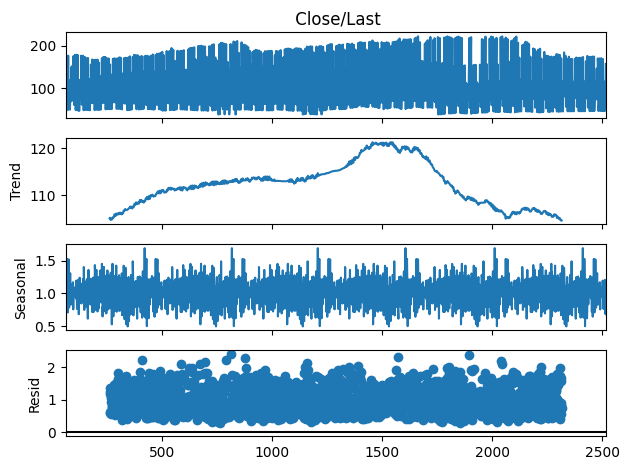

In [92]:
 #Descomposicion de la serie temporal
 #period=360 ya que parece que hay un ciclo
 descompuse_result=seasonal_decompose(df[' Close/Last'],model='multiplicative',period=360)
 descompuse_result.plot()
 plt.show()

###Verificar estacionariedad

In [93]:
#USAREMOS EL TEST DE DICKEY-FULLER
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
result = adfuller(df[' Close/Last'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -6.550233
p-value: 0.000000


Esto quiere decir lo siguiente
 Interpretación
p-value = 0.000000 (prácticamente 0):

* Esto está muy por debajo del umbral típico de 0.05.

* Rechazas la hipótesis nula (H₀): la serie NO es estacionaria.

Entonces, la serie sí es estacionaria.

* ADF Statistic = -7.93:

Este valor negativo indica una fuerte evidencia contra la no estacionariedad.

Cuanto más negativo sea el estadístico ADF, más segura es la evidencia de estacionaridad.



| Resultado               | Conclusión                                 |
| ----------------------- | ------------------------------------------ |
| ADF = -7.93             | Muy por debajo del umbral crítico          |
| p-value = 0.000         | Rechazas H₀ → la serie es **estacionaria** |
| ¿Necesitas diferenciar? | ❌ No, ya está lista                        |


No se necesits hacer diff

Haremos una ultima revision para saber si es estacionaria

In [94]:
result = adfuller(df[' Close/Last'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -6.550233
p-value: 0.000000


Conclusion deL Proceso de EDA
Se observa una clara

#Feauture Enginners (Ingenieria de caracteristicas)

¿Qué es esto?
Crear nuevas variables a partir de la serie original que ayuden al modelo a aprender mejor los patrones del tiempo

Es el proceso de
* Crear nuevas variables a apartir de las existentes
* Aplicar transformaciones matematicas
* Extraer patrones
* Crear lags o promedios moviles
* Codificar variables categoricas

####A. Lag Features (Caracteristicas rezagadas)
Esta simulara el recuerdo de la serie. Por ejemplo: ¿Cómo estaba el precio ayer? ¿Hace 7 dias?

In [95]:
#El precio de 1, 2 y 7 dias atras
df['lag_1']=df[' Close/Last'].shift(1)
df['lag_2']=df[' Close/Last'].shift(2)
df['lag_7']=df[' Close/Last'].shift(7)

/tmp/ipython-input-95-1863813472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag_1']=df[' Close/Last'].shift(1)
/tmp/ipython-input-95-1863813472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag_2']=df[' Close/Last'].shift(2)
/tmp/ipython-input-95-1863813472.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

Lo que hace es desplazarse un espacio hacia arriba o hacia abajo para formar una serie de tiempo

####B.Rolling  Statistics(Promedios moviles)
Muestra el comportamiento local de la serie. Son super utiles para suaviar y ver microtendencias

In [97]:
#media movil de los ultimos 3 y 7 dias
df['roll_mean_3']=df[' Close/Last'].rolling(window=3).mean()
df['roll_mean_7']=df[' Close/Last'].rolling(window=7).mean()

#desviacion estandar movil para ver la voratilidad
df['roll_std_7']=df[' Close/Last'].rolling(window=7).std()

/tmp/ipython-input-97-576995285.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['roll_mean_3']=df[' Close/Last'].rolling(window=3).mean()
/tmp/ipython-input-97-576995285.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['roll_mean_7']=df[' Close/Last'].rolling(window=7).mean()
/tmp/ipython-input-97-576995285.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [98]:
df.head(5)

,Date,Close/Last,Volume,Open,High,Low,media_30,lag_1,lag_2,lag_7,roll_mean_3,roll_mean_7,roll_std_7,diff_1,diff_2
65,01/11/2012,60.3643,53739093,60.3828,60.4071,59.9014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.5586,116.5529
66,01/11/2013,74.3285,87569116,74.4285,75.0457,74.1457,NaN,60.3643,NaN,NaN,NaN,NaN,NaN,13.9642,2.4056
67,01/11/2016,98.5300,49687870,98.9700,99.0600,97.3400,NaN,74.3285,60.3643,NaN,77.740933,NaN,NaN,24.2015,10.2373
68,01/11/2017,119.7500,27453130,118.7400,119.9300,118.6000,NaN,98.5300,74.3285,NaN,97.536167,NaN,NaN,21.2200,-2.9815
69,01/11/2018,175.2800,18653380,174.5900,175.4886,174.4900,NaN,119.7500,98.5300,NaN,131.186667,NaN,NaN,55.5300,34.3100


In [99]:
print(df['roll_mean_3'])

65             NaN
66             NaN
67       77.740933
68       97.536167
69      131.186667
           ...    
2512     79.308233
2513     67.416800
2514     88.850133
2515     98.595233
2516    124.460000
Name: roll_mean_3, Length: 2216, dtype: float64


rolling crea una ventana deslizante sobre la serie de tiempo, sirve para calcular estadisticas moviles como medias, sumas y deviaciones etc,  en bloques de vales consecutivos, en el codigo esta calculando el promedio de precios de cierre(Close) en ventnas de 3 y 7 dias, la desviacion estandar indica que tanto se estan alejando los datos del promedio

####C. Differencing
.diff() calcula la diferencia entre un valor y el valor anterior en una columno
elimina tendencia para modelos, esta vez solo se hara para si en todo caso no fuera estacionario. (solo es demostraivo)

In [100]:
#differencia simple
df['diff_1']=df[' Close/Last'].diff()

#differencing doble ( por si fuera necesarii )
df['diff_2']=df[' Close/Last'].diff().diff()

/tmp/ipython-input-100-3163656434.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_1']=df[' Close/Last'].diff()
/tmp/ipython-input-100-3163656434.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_2']=df[' Close/Last'].diff().diff()


Hay que eliminar los nuevos valores NaN

In [101]:
df.dropna(inplace=True)

In [102]:
df

,Date,Close/Last,Volume,Open,High,Low,media_30,lag_1,lag_2,lag_7,roll_mean_3,roll_mean_7,roll_std_7,diff_1,diff_2
97,01/16/2013,72.2985,172393952,70.6628,72.7771,70.3571,98.174267,153.0700,97.1300,99.5200,107.499500,104.051200,35.057585,-80.7715,-136.7115
98,01/16/2014,79.1785,57313035,79.2714,79.5500,78.8114,98.801407,72.2985,153.0700,150.0000,101.515667,93.933843,29.340070,6.8800,87.6515
99,01/16/2015,105.9900,78453330,107.0300,107.5800,105.2000,99.856790,79.1785,72.2985,69.4171,85.822333,99.158543,27.441563,26.8115,19.9315
100,01/16/2018,176.1900,29512410,177.9000,179.3900,176.1400,102.445457,105.9900,79.1785,79.6228,120.452833,112.953857,38.162507,70.2000,43.3885
101,01/16/2019,154.9400,30483120,153.0800,155.8800,153.0000,103.618457,176.1900,105.9900,106.8200,145.706667,119.828143,41.094774,-21.2500,-91.4500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,12/31/2012,76.0247,164519649,72.9328,76.4857,72.7143,100.384523,46.0800,115.8200,46.2371,79.308233,84.976986,27.601035,29.9447,99.6847
2513,12/31/2013,80.1457,55761100,79.1671,80.1828,79.1428,97.370380,76.0247,46.0800,57.8571,67.416800,88.161071,25.125641,4.1210,-25.8237
2514,12/31/2014,110.3800,41304780,112.8200,113.1300,110.2100,95.810713,80.1457,76.0247,79.2171,88.850133,92.612914,26.021597,30.2343,26.1133
2515,12/31/2015,105.2600,40885480,107.0100,107.0300,104.8200,97.773287,110.3800,80.1457,112.5200,98.595233,91.575771,25.228516,-5.1200,-35.3543


##Visualización de los datos
veremos cómo se comparan los precios reales con las lag feauteres y rolling stats, para ver si aportan valor

####1. Comparar Precio real vs Media Móvil

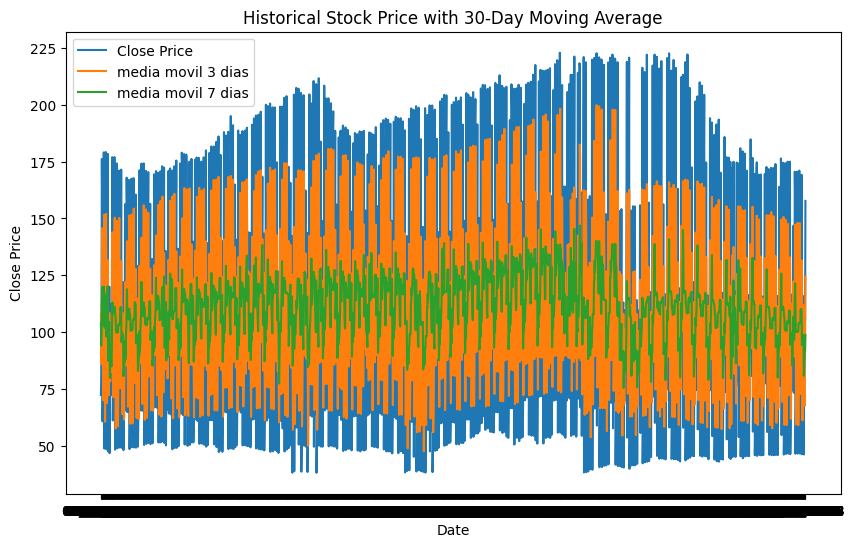

In [103]:
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df[' Close/Last'], label='Close Price')
plt.plot(df['Date'], df['roll_mean_3'], label='media movil 3 dias')
plt.plot(df['Date'], df['roll_mean_7'], label='media movil 7 dias')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Historical Stock Price with 30-Day Moving Average')
plt.legend()

####2. vizualizar lag features vs precio real

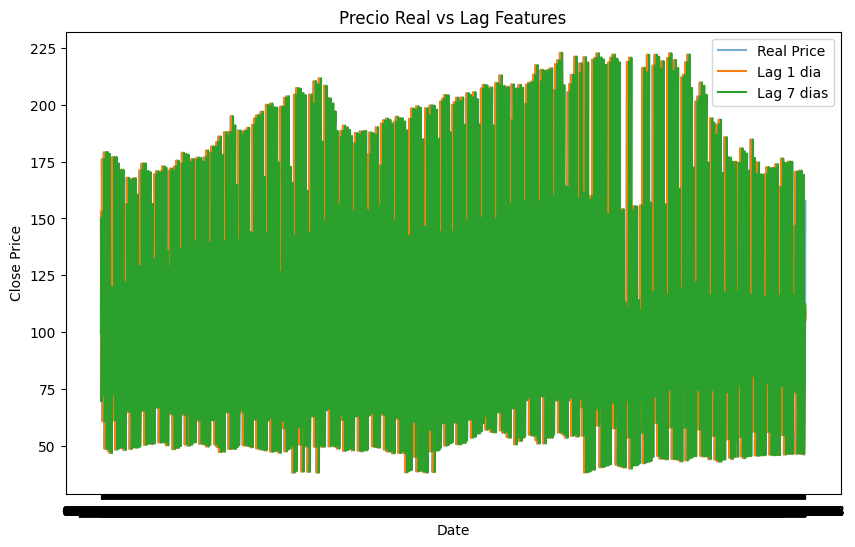

In [104]:
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df[' Close/Last'], label='Real Price', alpha=0.6)
plt.plot(df['Date'], df['lag_1'], label='Lag 1 dia')
plt.plot(df['Date'], df['lag_7'], label='Lag 7 dias')
plt.title('Precio Real vs Lag Features')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()


####3. Visualizar Differencing

Text(0.5, 0, 'Date')

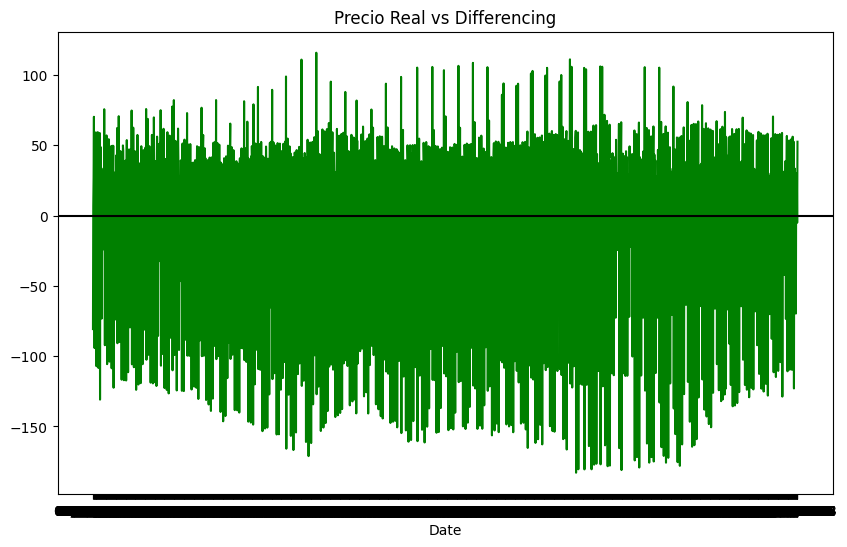

In [105]:
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['diff_1'], label='diferencia de 1 dia', color='green')
plt.axhline(0, color='black')
plt.title('Precio Real vs Differencing')
plt.xlabel('Date')

Se observan que la difference se comporta adecuadamente mostrando una fuerte correlacionc on el comportamiento del precio real.

#Model development
####Objetivo:
* Desarrollar el modelo que prediga precios futuros, usando datos historicos y tecnicas de series temporales

Pasos a seguir:
  * Dividir los datos en conjuntos de entrenamiento y prueba (Evaluar si el modelo puede generalizar a datos nuevos)
  * Aplica modelos de prediccion de series temporales (ARIMA, SARIMA) - Ajustar un modelo matematico que aprenda patrones del pasado y los use para predecir valores futuros.  
  * Predecir.

Meta final del paso es que se tenga un modelo entrenado que funcion, que ya este prediciendo fatos que no vio durante el entrenamiento y que puedas comparar con los resultados con la realidad


####Dividir datos en entrenamiento y prueba
Queremos saber si el modelo puede predecir datos que no ha visto
Usualmente se dejan los ultimos 30 dias  para prueba (test), el resto se usa para entrenar (train)

In [106]:
#En este caso para Arima no se usara sklearning por lo que se hara manual
train_size=int(len(df)*0.95)
train=df[' Close/Last'][:train_size]
test=df[' Close/Last'][train_size:]

print('entrenamiento', len(train))
print('prueba', len(test))

entrenamiento 2077
prueba 110


Se hace asi porque en series temporales NO puedes mezclar aleatoriamente los datos como hariamos en modelos clasicos. Aqui el orden importa, usaremos el pasado para predecir el futuro y no al reves

####Modelo ARIMA
Arima es un modelo estadistico(no machine learning) que se usa para predecir series temporales
tiene tres componentes:

| Componente | Significado             | ¿Qué hace?                                                      |
| ---------- | ----------------------- | --------------------------------------------------------------- |
| `p`        | **AR (autoregressive)** | Usa valores pasados (lags) como predictores.                    |
| `d`        | **I (integrated)**      | Aplica `d` veces differencing para hacer la serie estacionaria. |
| `q`        | **MA (moving average)** | Usa errores pasados para corregir predicciones.                 |

 Ejemplo real de cómo piensa el modelo:
"Para predecir el precio de hoy, voy a fijarme en:

* cómo estuvieron los últimos p días (AR)

* si hay una tendencia o patrón que necesito eliminar (d)

* cuánto me equivoqué en días anteriores para corregirme (MA)"

Tenemos encuenta que nuestra serie es estacuinaria, asi que usaremos d=0

In [107]:
from statsmodels.tsa.arima.model import ARIMA
#Entrenar el modelo ARIMA
model=ARIMA(train, order=(5,0,2))#p=5 considera los ulgimos 5 valores para predecir el siguuente
#d=0 ya no aplica porque ya es estacionario
#q=2 usa los errores de prediccion de los ultimos 2 dias para mejorar
model_fit=model.fit() #Se entreja el modelo con los datos de entrenamiento

#Genera predicciones para el periodo de prueva
forecast = model_fit.forecast(steps=len(test)) #Genera las predicciones para el mismo numero de dias que hay en test

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

####Visualizaremos la prediccion vs realidad

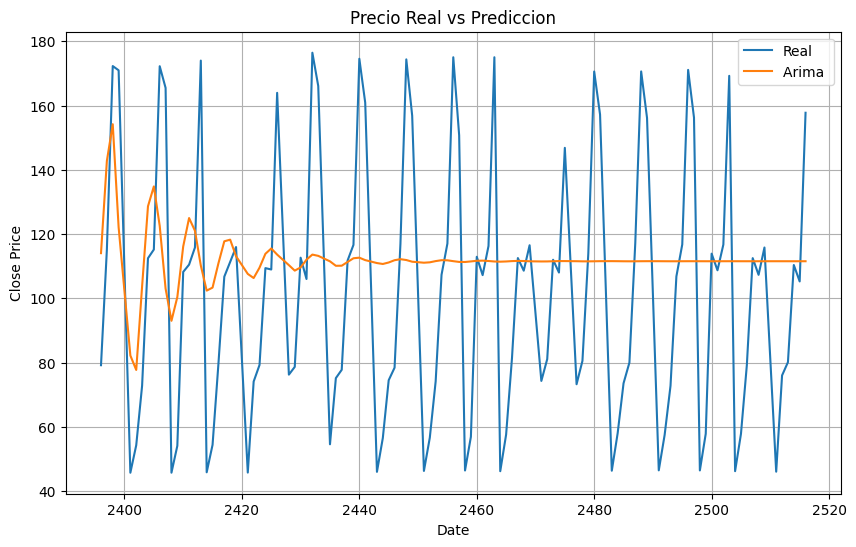

In [108]:
plt.figure(figsize=(10,6))
plt.plot(test.index, test, label='Real')
plt.plot(test.index, forecast, label='Arima ')
plt.title('Precio Real vs Prediccion')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

####Modelo SARIMA
Es ARIMA + Estacionalidad(por si hay patrones que se repiten cada X dias)
Lo mismo que p,d,q pero para ciclos repetidos
s= numero de pasos que dura un ciclo

In [109]:
# Creamos un modelo SARIMA (Seasonal ARIMA) con:
# order = (p, d, q) → mismos componentes que ARIMA:
#    p = 5 → considera los últimos 5 valores (autoregresivo)
#    d = 0 → no aplica differencing (ya es estacionaria)
#    q = 2 → usa 2 errores pasados para ajustar la predicción

# seasonal_order = (P, D, Q, S) → componentes estacionales:
#    P = 1 → componente autoregresivo estacional (usa 1 valor del mismo punto en el ciclo anterior)
#    D = 1 → diferencia estacional (para eliminar estacionalidad si existe)
#    Q = 1 → media móvil estacional (usa 1 error estacional previo)
#    S = 30 → estacionalidad cada 30 días (por ejemplo, mensual si tus datos son diarios)


In [110]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
#Suponiendo que hay una estacionalidad cada 30 dias (puedes cambiar "s")
model_sarima = SARIMAX(train, order=(5, 0, 2), seasonal_order=(1, 1, 1, 30))
model_sarima_fit = model_sarima.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [111]:
#Predecir
sarima_forecast=model_sarima_fit.forecast(steps=len(test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


####Visualizaremos preddiccion vs real

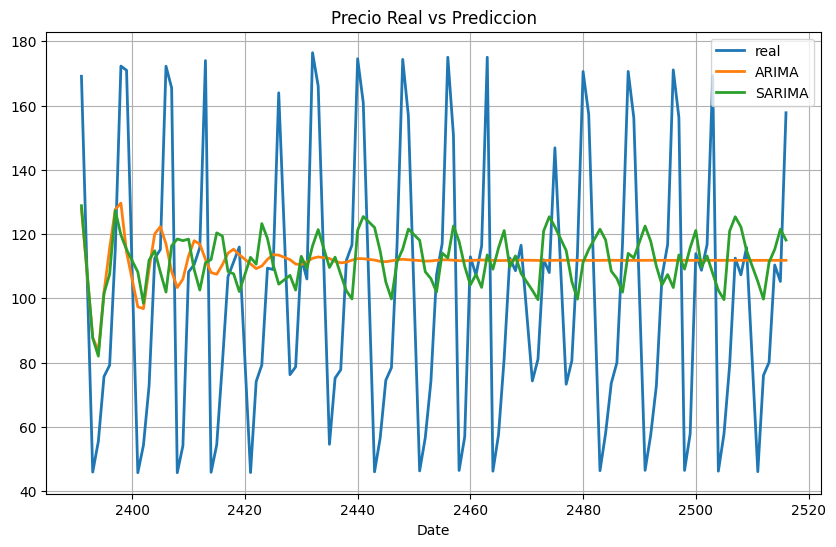

In [85]:
plt.figure(figsize=(10,6))
plt.plot(test.index, test, label='real', linewidth=2)
plt.plot(test.index, forecast, label='ARIMA', linewidth=2)
plt.plot(test.index, sarima_forecast, label='SARIMA', linewidth=2)
plt.title('Precio Real vs Prediccion')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

#Model Evaluation (Evaluacion del modelo)
Se encarga de medir qué tan bien predicen los modelos comparando sus resultados con los datos reales

####Objetivo:
Medor qué tan bein predicen los modelos comparando sus resultados con los datos reales

Aqui haremos:
1. Evaluar con Metricas

  Usamos:
  - MAE(Mean Absolute Error)
  - RMSE (Root Mean Squared Error)

  Las metricas te dicen cuanto se equivoca el modelo, en promedio

2. Comparar visualmente
  
    Graficamos:
    - Precio real
    - Predicción ARIMA
    - Prediccion SARIMA

    Para ver si los modelos siguen bien la tendencia o andan perdidos



####Metricas ARIMA

In [86]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_ARIMA=mean_absolute_error(test, forecast)
rmse_ARIMA=np.sqrt(mean_squared_error(test, forecast))

print('MAE ARIMA:', mae_ARIMA)
print('RMSE ARIMA:', rmse_ARIMA)

MAE ARIMA: 33.55334575268779
RMSE ARIMA: 40.768428110537464


####Metricas SARIMA

In [87]:
mae_SARIMA=mean_absolute_error(test, sarima_forecast)
rmse_SARIMA=np.sqrt(mean_squared_error(test, sarima_forecast))

print('MAE SARIMA:', mae_SARIMA)
print('RMSE SARIMA:', rmse_SARIMA)

MAE SARIMA: 34.56014851116215
RMSE SARIMA: 41.60566773832248


####Comparar Gráficamente

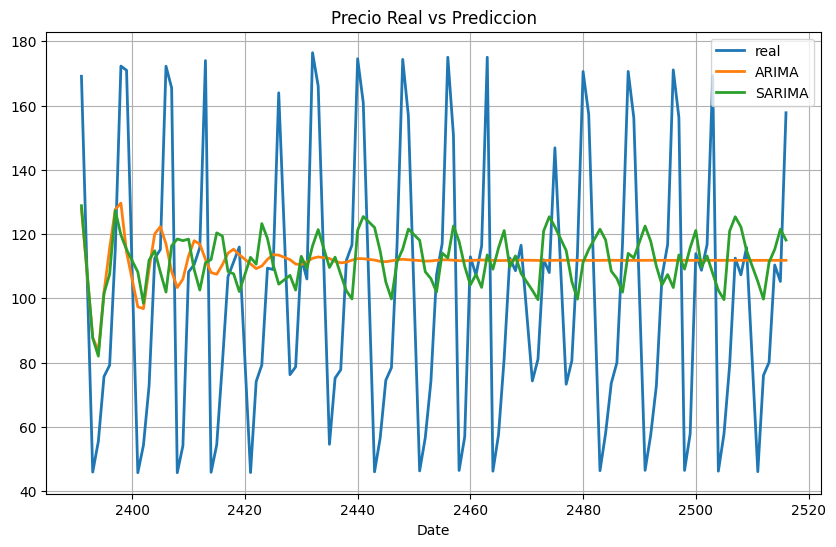

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(test.index, test, label='real', linewidth=2)
plt.plot(test.index, forecast, label='ARIMA', linewidth=2)
plt.plot(test.index, sarima_forecast, label='SARIMA', linewidth=2)
plt.title('Precio Real vs Prediccion')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

Al comparar ambos modelos, ARIMA mostró una tendencia a aplanarse con el tiempo, generando una curva de predicción que pierde variabilidad, lo cual indica que no logra capturar adecuadamente la dinámica real del mercado.

Por otro lado, SARIMA logró mantener un patrón similar al comportamiento real, especialmente en las fluctuaciones de corto plazo, lo cual sugiere la presencia de estacionalidad en los precios de cierre de Apple.

Aunque los errores (MAE y RMSE) pueden ser similares en magnitud, SARIMA es claramente superior visualmente, ya que refleja de forma más fiel los movimientos reales del precio, sin aplanarse.



#Hyperparameter Tuning

###Objetivo
* (Optimizar los parametros del modelo para obtner una mejor precision) Buscar los mejores valores posibles de los hiperparametro del modelo(como p,d,q,P,D,Q,s) para que el modleo prediga mejor

####Es importante
Porque automatiza ese proceso, para encontrar la mejor combinación con la menor cantidad de error (MAE, AIC o BIC), esto quiere decir que el modelo haga prueba y erro con distintas configuraciones para encontrar la que predice mejor

Vamos a hacer el Hyperparameter Tuning usando auto_arima, que es la forma más pro y practica de buscar los mejores valores de (p, d , q) y tambien los parametros estacionales (P,D,Q,s) si estas usando SARIMA.

In [77]:
!pip install pmdarima


Usaremos auto_aruna para encontrar los mejores parametros

In [2]:
from pmdarima import auto_arima
#Entrenamos el auto_arima con tus datos de entrenamiento
from pmdarima import auto_arima

# Entrena el auto_arima con tus datos de entrenamiento
model_auto = auto_arima(
    train,                     # tu serie de entrenamiento
    seasonal=True,             # True si hay estacionalidad
    m=30,                      # frecuencia estacional (ej. 30 si hay ciclos mensuales)
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    d=0,                       # ya es estacionaria
    D=1,                       # un paso
    trace=True,               # para ver visualizar
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True              # para que lo haga rápido
)


NameError: name 'train' is not defined

####Ver los mejores parámetros

In [1]:
print(model_auto.summary())

NameError: name 'model_auto' is not defined

It seems like there's an incompatibility between the versions of the libraries installed, specifically with numpy. This often happens when libraries are installed in a specific order or have conflicting dependencies. To fix this, please restart the runtime by going to "Runtime" -> "Restart runtime..." in the Colab menu, and then run the following cell to reinstall the necessary libraries.

After the libraries are reinstalled, you can continue running the notebook from the beginning.

Let's try a more explicit reinstallation process to resolve the `numpy.dtype size changed` error. Please restart the runtime again before running the following cell.

After running the cell above, please try running the `auto_arima` cell (`yFNdQR7fS8jO`) again.